In [1]:
import torch
from data_utils import GuidedGridMLMDataset, GuidedGridMLM_collate_fn
from torch.utils.data import DataLoader
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from tqdm import tqdm
import numpy as np

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device_name = 'cuda:0'
val_dir = '/media/maindisk/data/hooktheory_hr/hooktheory_CA_test'
jazz_dir = '/media/maindisk/data/gjt_melodies/gjt_CA'
subfolder = 'CA'
curriculum_type='random'
ablation = 'all'

In [3]:
model_path = 'saved_models/' + subfolder + '/' + curriculum_type + '_' + ablation + '.pt'
tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
val_dataset = GuidedGridMLMDataset(val_dir, tokenizer, 512, frontloading=True)
jazz_dataset = GuidedGridMLMDataset(jazz_dir, tokenizer, 512, frontloading=True)

Loading data file.
Loading data file.


In [4]:
if device_name == 'cpu':
        device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
vae_cfg = {
    'input_dim': 512,
    'hidden_dim': 256,
    'latent_dim': 128,
    'embedding_dim': 64,
    'seq_len': 256,
    'feature_dim': 37,
}
encoder_cfg = {
    'nhead': 8,
    'num_layers': 8,
    'stage_embedding_dim': 64,
    'max_stages': 10
}
model = GuidedMLMH(
    vae_cfg=vae_cfg,
    encoder_cfg=encoder_cfg,
    chord_vocab_size=len(tokenizer.vocab),
    d_model=512,
    conditioning_dim=16,
    pianoroll_dim=100,
    grid_length=256,
    guidance_dim=128,
    unfold_latent=True,
    device=device,
)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GuidedMLMH(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (guidance_to_dmodel): Linear(in_features=128, out_features=512, bias=True)
  (vae): GuidanceVAE(
    (embedding): Embedding(354, 64)
    (encoder_rnn): LSTM(64, 256, batch_first=True)
    (mu_proj): Linear(in_features=256, out_features=128, bias=True)
    (logvar_proj): Linear(in_features=256, out_features=128, bias=True)
    (decoder_rnn): LSTM(128, 256, batch_first=True)
    (recon_proj): Linear(in_features=256, out_features=354, bias=True)
    (feature_proj): Linear(in_features=128, out_features=37, bias=True)
  )
  (encoder): GridMLMMelHarmEncoder(
    (stage_embedding): Embedding(10, 64)
    (stage_proj): Linear(in_features=576, out_features=512, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): 

In [5]:
def condenced_str_from_token_ids(inp_ids, tokenizer):
    tmp_str = ''
    tmp_count = 0
    prev_id = -1
    num_chords = 0
    for t in inp_ids:
        if prev_id == t:
            tmp_count += 1
        else:
            if prev_id != -1:
                tmp_str += f'{tmp_count}x{tokenizer.ids_to_tokens[prev_id]}'
                num_chords += 1
                if num_chords == 4:
                    tmp_str += '\n'
                    num_chords = 0
                else:
                    tmp_str += '_'
            tmp_count = 1
            prev_id = t
    tmp_str += f'{tmp_count}x{tokenizer.ids_to_tokens[prev_id]}'
    return tmp_str
# end condenced_str_from_token_ids

zs = []
z_idxs = []
z_tokens = []
for d in tqdm(val_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z_tokens.append(condenced_str_from_token_ids(d['input_ids'], tokenizer))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)
for d in tqdm(jazz_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z_tokens.append(condenced_str_from_token_ids(d['input_ids'], tokenizer))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(1)

100%|██████████| 547/547 [00:02<00:00, 262.24it/s]


In [6]:
print(z_tokens[10])

198xA:min_6xG#:dim_6xG:5_6xF#:min
4xF:maj_4xE:maj_16xF:maj_16x<pad>


In [7]:
z_np = np.array( zs )

In [8]:
print(z_np.shape)

(1027, 128)


In [9]:
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [10]:
# y = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=2).fit_transform(z_np)
pca = PCA(n_components=2)
y = pca.fit_transform( z_np )

In [11]:
print(y.shape)

(1027, 2)


In [12]:
import matplotlib.pyplot as plt

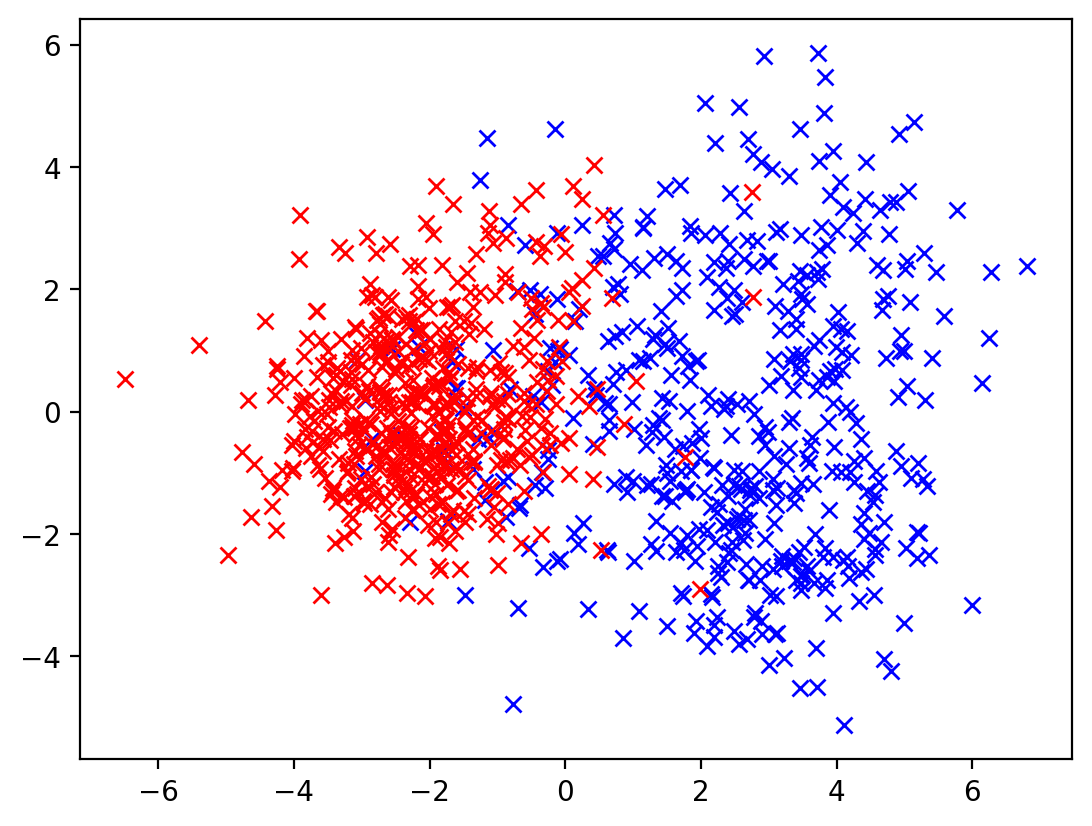

In [13]:
plt.plot(y[:len(val_dataset),0], y[:len(val_dataset),1], 'bx')
plt.plot(y[len(val_dataset):,0], y[len(val_dataset):,1], 'rx')

In [15]:
import numpy as np
import plotly.express as px
import pandas as pd

custom_colors = ['#1f77b4', '#ff7f0e']  # blue and orange

# Example inputs (replace with your actual data)
# z_tsne: Nx2 array
# z_idxs: list of ints (classes)
# z_tokens: list of strings

# Combine into a DataFrame for easy Plotly integration
df = pd.DataFrame({
    'x': y[:, 0],
    'y': y[:, 1],
    'class': z_idxs,
    'token': z_tokens
})

df['hover_text'] = df['token'].str.replace('\n', '<br>')
df['class_str'] = df['class'].astype(str)

# Create interactive scatter plot
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='class_str',
    hover_data=None,
    color_discrete_sequence=custom_colors
    # hover_name='token',  # This will show on hover
    # title='2D Visualization',
)

fig.update_layout(
    xaxis=dict(scaleanchor='y', scaleratio=1),  # Equal aspect ratio
)

fig.update_traces(
    hovertemplate=df['hover_text']
)

# Show the figure in notebook
fig.show()
